# This is a pipeline to visualize and analyze the results of CellProfiler on Rabies experiments

In [1]:
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader, plot_utils
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
from PIL import Image
from matplotlib import cm

In [ ]:
# Select the path where the data is (where the CellProfiler folder is)
Data_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Rabies_Tracing/NAc-D1_D2/SP8_NAc_BLA_dataset/DataForAnalysis/'
# Read it in a useful format
RabiesData, cFosData = data_reader.RabiesCP_data_reader(Data_path + 'CellProfilerOutput/')
# Create out directory if it does not exist
outputDir = Data_path + 'JupyterOutput/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [ ]:
RabiesData

In [ ]:
# cell area size
fig, axs = plt.subplots(1,2, figsize=(17,5))
axs = axs.ravel()
sns.distplot(RabiesData.Area, bins=100, ax = axs[0])
axs[0].set_title('Rabies cell size')
sns.distplot(cFosData.Area, bins=100, ax = axs[1])
axs[1].set_title('cFos object size')
plt.savefig(outputDir + 'Sizes_distribution.pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# filter by size, side of the brain, procedure, and cFos threshold
SIZE_FILTER = 150
BRAIN_SIDE = 'contra' # ipsi vs contra
CFOS_CONDITION = 'reward' # reward vs punish
CFOS_PERCENTILE = 'cFosPercentile_med_Object' # low, med, high

RabiesDataSF = RabiesData[RabiesData['Area'] > SIZE_FILTER]
cFosDataSF = cFosData

RabiesDataSF = RabiesDataSF[RabiesDataSF['BrainSide'] == BRAIN_SIDE]
cFosDataSF = cFosDataSF[cFosDataSF['BrainSide'] == BRAIN_SIDE]

RabiesDataSF = RabiesDataSF[RabiesDataSF['cFosCondition'] == CFOS_CONDITION]
cFosDataSF = cFosDataSF[cFosDataSF['cFosCondition'] == CFOS_CONDITION]

In [ ]:
TotalRabiesD1 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D1'])
TotalRabiesD2 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D2'])
TotalcFosD1 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D1', cFosDataSF['PercentileInfo']==CFOS_PERCENTILE)])
TotalcFosD2 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D2', cFosDataSF['PercentileInfo']==CFOS_PERCENTILE)])
TotalRabiesAndcfosD1 = len(RabiesDataSF[np.logical_and(RabiesDataSF[CFOS_PERCENTILE]!=0, RabiesDataSF['StarterCells']=='D1')])
TotalRabiesAndcfosD2 = len(RabiesDataSF[np.logical_and(RabiesDataSF[CFOS_PERCENTILE]!=0, RabiesDataSF['StarterCells']=='D2')])

print('Total rabies cells:')
print('D1: ',str(TotalRabiesD1))
print('D2: ',str(TotalRabiesD2))

print('\nTotal c-Fos objects:')
print('D1: ',str(TotalcFosD1))
print('D2: ',str(TotalcFosD2))

print('\nTotal rabies cells with c-Fos:')
print('D1: ',str(TotalRabiesAndcfosD1))
print('D2: ',str(TotalRabiesAndcfosD2))

# Maybe this is not a good way of normalizing using the c-Fos (e.g. this is not robust to only c-Fos images).
# One way could be to normalize the c-Fos by the c-Fos density? (total cFos / total image area)

print('\nPercentage overlap of rabies and c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / (TotalcFosD1 + TotalRabiesD1)), '%')
print('D2: ',str(100 * TotalRabiesAndcfosD2 / (TotalcFosD2 + TotalRabiesD2)), '%')

print('\nProportion of rabies cells with c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / TotalRabiesD1), '%')
print('D2: ',str(100 * TotalRabiesAndcfosD2 / TotalRabiesD2), '%')

In [ ]:
# Create a nice barplot summarizing this
def createBPdata(rabiesDF, cFosColumn):
    
    newdf = pd.DataFrame(columns=['AnimalID', 'BrainSide', 'Condition', 'StarterCells', 'Prop_of_rab_with_cfos', 'BrSdAndCond'])
    
    # calculate the percentage of overlap for each combination
    for ai in pd.unique(rabiesDF.AnimalID):
        rab = rabiesDF[rabiesDF['AnimalID'] == ai]
        sc = pd.unique(rab.StarterCells)[0]
        cfcond = pd.unique(rab.cFosCondition)[0]
        for bs in pd.unique(rabiesDF.BrainSide):
            side_rab = rab[rab['BrainSide'] == bs]
            TotalRabies = len(side_rab)
            TotalRabiesAndcfos = len(side_rab[side_rab[cFosColumn] != 0])
            Proportion = 100 * TotalRabiesAndcfos / TotalRabies

            newdf = newdf.append({'AnimalID': ai,
                                  'BrainSide': bs,
                                  'Condition': cfcond,
                                  'StarterCells': sc,
                                  'Prop_of_rab_with_cfos': Proportion,
                                  'BrSdAndCond': cfcond + ' ' + bs},
                                 ignore_index = True)
    return newdf


RabiesDataSF = RabiesData[RabiesData['Area'] > SIZE_FILTER]
cFosDataSF = cFosData

df_for_bp = createBPdata(RabiesDataSF, CFOS_PERCENTILE)

In [ ]:
fig, ax = plt.subplots(figsize=(17,5))
#ax.axhline(50, ls='--', alpha=0.4, color='k')
sns.barplot(x='BrSdAndCond', y='Prop_of_rab_with_cfos', hue='StarterCells', data=df_for_bp)
lgd = plt.legend(loc=(0,1.1), borderaxespad=0., ncol = 4, frameon=True)
plt.xticks(horizontalalignment="right", rotation=45)

plt.savefig(outputDir + 'Proportion_of_rabies_with_cfos.pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# explore the dataset, plotting a random subset of cells
NumOfSamples = 36
# get the indexes of d1 and d2 cohorts
d1shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')].index.values
d2shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')].index.values
# shuffle them
np.random.shuffle(d1shuffledIdx)
np.random.shuffle(d2shuffledIdx)
# join
IdxToPlot = list(d1shuffledIdx[0:int(NumOfSamples/2)]) + list(d2shuffledIdx[0:int(NumOfSamples/2)])
# plot
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(5*NumOfSamples/3)))
for counter,i in enumerate(IdxToPlot):
    CellImage = plot_utils.plotRabiesCell(RabiesData.iloc[i], Data_path, window=20, lut='plasma')
    plt.subplot(NumOfSamples, 3, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i) + " - " + RabiesData.iloc[i]['StarterCells'])
    plt.imshow(CellImage)

plt.savefig(outputDir + 'Cell_survey.pdf', transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')




In [209]:
RabiesData[['cFosPercentile_med_Object', 'cFosPercentile_high_Object']].apply(len)

cFosPercentile_med_Object     981
cFosPercentile_high_Object    981
dtype: int64

In [195]:
RabiesDataSF[np.logical_and(RabiesDataSF['ImageNumber']==1, np.logical_or(
                            RabiesDataSF['RabiesCellNumber']==23, RabiesDataSF['RabiesCellNumber']==24))]

,ImageNumber,RabiesCellNumber,Area,Center_X,Center_Y,MeanIntensity_cfos,MeanIntensity_rabies,cFosPercentile_high_Object,cFosPercentile_low_Object,cFosPercentile_med_Object,AnimalID,StarterCells,cFosCondition,SliceNumber,BrainSide,InjectionArea
22,1.0,23.0,429.0,281.0,455.0,0.074903,0.260432,0.0,19.0,0.0,893271,D2,Punish,Slice6,Contra,TODO
23,1.0,24.0,302.0,226.0,507.0,0.072419,0.345708,0.0,0.0,0.0,893271,D2,Punish,Slice6,Contra,TODO


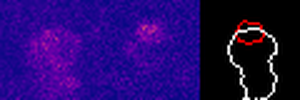

In [196]:
plot_utils.plotRabiesCell(RabiesData.iloc[22], Data_path, window=20, lut='plasma')

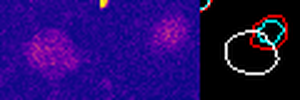

In [197]:
plot_utils.plotRabiesCell(RabiesData.iloc[23], Data_path, window=20, lut='plasma')

In [ ]:
# Check and maybe filter different parameters